In [132]:
PRFX='Dev0724-2'

In [133]:
!pip install ../input/efficientnetpytorch/efficientnet_pytorch-0.3.0-py3-none-any.whl

In [134]:
!nvidia-smi

Thu Jul 25 02:52:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   42C    P0    38W / 300W |   1073MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [135]:
# Downloading: "http://storage.googleapis.com/public-models/efficientnet-b3-c8376fa2.pth" to /tmp/.cache/torch/checkpoints/efficientnet-b3-c8376fa2.pth
import os
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')

!cp ../input/efficientnetpytorch/*.pth /tmp/.cache/torch/checkpoints/

# params

In [218]:
p_o = f'../output/{PRFX}'
from pathlib import Path
Path(p_o).mkdir(exist_ok=True)

SEED = 111

BS = 4#16
FP16 = True
PERC_VAL = 0.2
WD = 0.1


MODEL_NAME = 'efficientnet-b3'
from efficientnet_pytorch import EfficientNet
SZ = EfficientNet.get_image_size(MODEL_NAME)
for i in range(6):
    print(f'efficientnet-b{i} size', EfficientNet.get_image_size(f'efficientnet-b{i}'))
print('SZ:', SZ)

from fastai.vision import *
params_tfms = {}


efficientnet-b0 size 224
efficientnet-b1 size 240
efficientnet-b2 size 260
efficientnet-b3 size 300
efficientnet-b4 size 380
efficientnet-b5 size 456
SZ: 300


In [219]:
SZ=512

## img proc

In [220]:
use_center_crop = False

> get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None) → Collection[Transform]

In [221]:
from fastai.vision import *
params_tfms = dict(
    max_rotate=0,
    max_zoom=1,
    max_warp=0,
    max_lighting=0,
)

> By default, the library resizes the image while keeping its original ratio so that the smaller size corresponds to the given size, then takes a crop (ResizeMethod.CROP). You can choose to resize the image while keeping its original ratio so that the bigger size corresponds to the given size, then take a pad (ResizeMethod.PAD). Another way is to just squish the image to the given size (ResizeMethod.SQUISH).

In [222]:
kwargs_tfms = dict(
    resize_method=ResizeMethod.SQUISH,
    padding_mode='zeros'
)

keep_less=0.83

# setup

## image processing

In [248]:
def crop_margin(image, keep_less=0.83):
    
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        #print('no contours!')
        flag = 0
        return image, flag
    cnt = max(contours, key=cv2.contourArea)
    ((x, y), r) = cv2.minEnclosingCircle(cnt)
    r = r*keep_less
    x = int(x); y = int(y); r = int(r)
    flag = 1
    #print(x,y,r)
    if r > 100:
        return output[0 + (y-r)*int(r<y):-1 + (y+r+1)*int(r<y),0 + (x-r)*int(r<x):-1 + (x+r+1)*int(r<x)], flag
    else:
        #print('none!')
        flag = 0
        return image,flag

    
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
# https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
def center_crop(img):        
    
    h0, w0 = 480, 640 #most common in test
    ratio = h0/w0 #most common in test
    height, width, _= img.shape
    new_width, new_height = width, math.ceil(width*ratio)

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

def load_ben_color(fn)->Image:
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = crop_image_from_gray(image)
    image, _ = crop_margin(image)

    if use_center_crop:
        image = center_crop(image)

    image = cv2.resize(image, (SZ, SZ))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX=10) , -4 ,128)
    return image

def open_yz(fn, convert_mode, after_open)->Image:
    image = load_ben_color(fn)
    return Image(pil2tensor(image, np.float32).div_(255))
    
vision.data.open_image = open_yz

## QWK

In [249]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

import cv2

import scipy as sp
from sklearn.metrics import cohen_kappa_score

In [225]:
def quadratic_weighted_kappa(y1, y2):
    return cohen_kappa_score(y1, y2, weights='quadratic')

def qwk(y_pred, y):
    return torch.tensor(
        quadratic_weighted_kappa(torch.round(y_pred), y),
        device='cuda:0')

## set seed

In [226]:
def set_torch_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_torch_seed()

## TTTA

In [227]:
from fastai.core import *
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.torch_core import *
def _tta_only(learn:Learner, ds_type:DatasetType=DatasetType.Valid, num_pred:int=5) -> Iterator[List[Tensor]]:
    "Computes the outputs for several augmented inputs for TTA"
    dl = learn.dl(ds_type)
    ds = dl.dataset
    old = ds.tfms
    aug_tfms = [o for o in learn.data.train_ds.tfms if o.tfm !=zoom]
    try:
        pbar = master_bar(range(num_pred))
        for i in pbar:
            ds.tfms = aug_tfms
            yield get_preds(learn.model, dl, pbar=pbar)[0]
    finally: ds.tfms = old

Learner.tta_only = _tta_only

def _TTA(learn:Learner, beta:float=0, ds_type:DatasetType=DatasetType.Valid, num_pred:int=5, with_loss:bool=False) -> Tensors:
    "Applies TTA to predict on `ds_type` dataset."
    preds,y = learn.get_preds(ds_type)
    all_preds = list(learn.tta_only(ds_type=ds_type, num_pred=num_pred))
    avg_preds = torch.stack(all_preds).mean(0)
    if beta is None: return preds,avg_preds,y
    else:            
        final_preds = preds*beta + avg_preds*(1-beta)
        if with_loss: 
            with NoneReduceOnCPU(learn.loss_func) as lf: loss = lf(final_preds, y)
            return final_preds, y, loss
        return final_preds, y

Learner.TTA = _TTA

## optimizer

In [228]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/88773#latest-515044
# We used OptimizedRounder given by hocop1. https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
# put numerical value to one of bins
def to_bins(x, borders):
    for i in range(len(borders)):
        if x <= borders[i]:
            return i
    return len(borders)

class Hocop1OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -quadratic_weighted_kappa(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [1.5, 2.0, 2.5, 3.0]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(1, 2), (1.5, 2.5), (2, 3), (2.5, 3.5)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']


# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
class AbhishekOptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

    
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

# pretraining using old data

## prep

In [229]:
img2grd = []

p = '../input/diabetic-retinopathy-detection'
pp = Path(p)

train=pd.read_csv(pp/'trainLabels.csv')
train=pd.read_csv(pp/'trainLabels.csv')
img2grd_diab_train=[(f'../input/diabetic-retinopathy-detection/train_images/{o[0]}.jpeg',o[1],'diab')  for o in train.values]
img2grd += img2grd_diab_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

test=pd.read_csv(pp/'retinopathy_solution.csv')
img2grd_diab_test=[(f'../input/diabetic-retinopathy-detection/test_images/{o[0]}.jpeg',o[1],'diab')  for o in test.values]
img2grd += img2grd_diab_test
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())


35126

[(0, 25810), (2, 5292), (1, 2443), (3, 873), (4, 708)]

88702

[(0, 65343), (2, 13153), (1, 6205), (3, 2087), (4, 1914)]

In [230]:
p = '../input/IDRID/B. Disease Grading'
pp = Path(p)

train=pd.read_csv(pp/'2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')
img2grd_idrid_train=[(f'../input/IDRID/B. Disease Grading/1. Original Images/a. Training Set/{o[0]}.jpg',o[1],'idrid')  for o in train.values]
img2grd += img2grd_idrid_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

test=pd.read_csv(pp/'2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv')
img2grd_idrid_test=[(f'../input/IDRID/B. Disease Grading/1. Original Images/b. Testing Set/{o[0]}.jpg',o[1],'idrid')  for o in test.values]
img2grd += img2grd_idrid_test
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

89115

[(0, 65477), (2, 13289), (1, 6225), (3, 2161), (4, 1963)]

89218

[(0, 65511), (2, 13321), (1, 6230), (3, 2180), (4, 1976)]

In [231]:
if not np.all([Path(o[0]).exists() for o in img2grd]): print('Some files are missing!!!')

In [232]:
df_ext = pd.DataFrame(img2grd)
df_ext.columns = ['fnm', 'target', 'src']
df_ext = df_ext.reset_index()
df_ext.shape

(89218, 4)

## select data2use

http://localhost:8888/notebooks/data/git/blnd/nbs/DevLookSubmDistr.ipynb#

    2    1050
    3     373
    0     321
    1     138
    4      46

In [233]:
t2c_perhaps = {2:    1050,
3:     373,
0:     321,
1:     138,
4:      46,}
{t:int(c*5) for t,c in t2c_perhaps.items()}

{2: 5250, 3: 1865, 0: 1605, 1: 690, 4: 230}

In [234]:
t2c_external = dict(df_ext.target.value_counts())
t2c_external

{0: 65511, 2: 13321, 1: 6230, 3: 2180, 4: 1976}

In [235]:
t2c_wanted = {2: 5300, 3: 1900, 0: 1700, 1: 700, 4: 300}

In [236]:
def sample_df_ext():
    idx2use = []
    for t,c_val in t2c_wanted.items():
        idx_t = np.where(df_ext.target==t)[0]
        idx_t_2use = np.random.choice(idx_t, c_val, replace=False)
        idx2use += list(idx_t_2use)
    return df_ext.iloc[idx2use]

In [237]:
df_ext_sample = sample_df_ext()

In [238]:
df_ext_sample.target.value_counts()

2    5300
3    1900
0    1700
1     700
4     300
Name: target, dtype: int64

## val set

In [239]:
img2grd = []

p = '../input/aptos2019-blindness-detection'
pp = Path(p)
train = pd.read_csv(pp/'train.csv')
len_blnd = len(train)

img2grd_blnd = [(f'{p}/train_images/{o[0]}.png',o[1],'blnd')  for o in train.values]

img2grd += img2grd_blnd
display(len(img2grd))
cnt = Counter(o[1] for o in img2grd)
t2c_trn_has = dict(cnt)
display(cnt.most_common())
sm = sum(cnt.values())
display([(o[0], o[1]/sm) for o in cnt.most_common()])

3662

[(0, 1805), (2, 999), (1, 370), (4, 295), (3, 193)]

[(0, 0.4929000546149645),
 (2, 0.272801747678864),
 (1, 0.1010376843255052),
 (4, 0.08055707263790278),
 (3, 0.052703440742763515)]

In [240]:
if not np.all([Path(o[0]).exists() for o in img2grd]): print('Some files are missing!!!')

In [241]:
df_blnd = pd.DataFrame(img2grd)
df_blnd.columns = ['fnm', 'target', 'src']
df_blnd = df_blnd.reset_index()
df_blnd.shape

(3662, 4)

## dataset

In [250]:
%%time
tfms = get_transforms(**params_tfms)

def get_data_pretrn():
    
    df_trn = sample_df_ext().copy()
    df_val = df_blnd
    df_trn['is_val'] = False
    df_val['is_val'] = True
    df_pretrn = pd.concat([df_trn, df_val],ignore_index=True)
    
    src = (ImageList.from_df(df=df_pretrn,path='./',cols='fnm') 
            .split_from_df(col='is_val') 
            .label_from_df(cols='target',  
                           label_cls=FloatList)
          )

    data = (src.transform(tfms, size=SZ,
                         **kwargs_tfms
                         ) #Data augmentation
            .databunch(bs=BS) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data

set_torch_seed()
data = get_data_pretrn()

CPU times: user 3.75 s, sys: 473 ms, total: 4.22 s
Wall time: 3.25 s


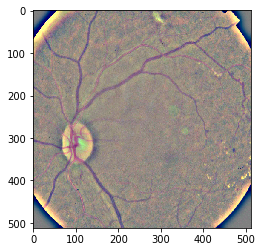

In [251]:
fn = df_ext.fnm.sample().values[0]
fn = "../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png"
image = load_ben_color(fn)
plt.imshow(image)

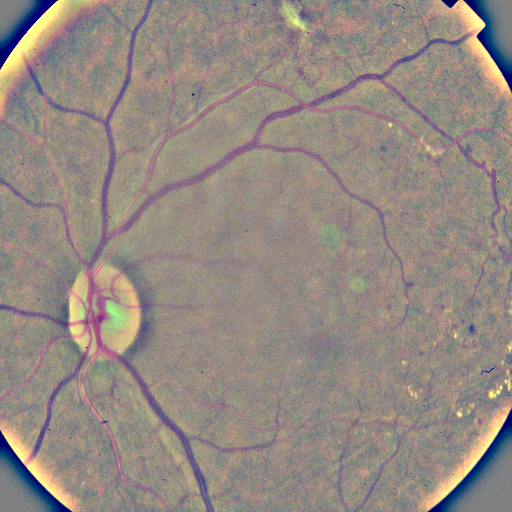

In [252]:
open_yz(fn,None,None)

CPU times: user 304 ms, sys: 614 ms, total: 918 ms
Wall time: 7.46 s


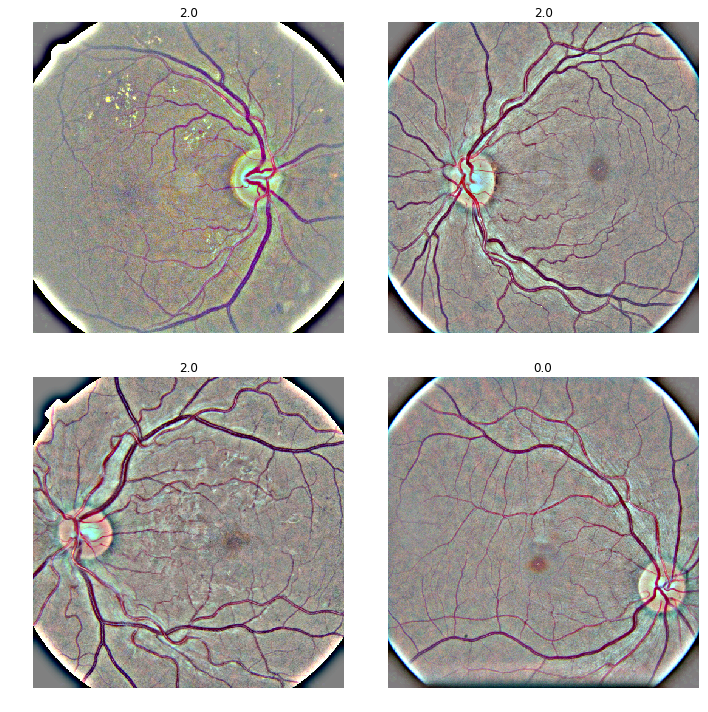

In [253]:
%%time
data.show_batch(rows=4, figsize=(10, 10))

# training using comp data

## prep

In [41]:
img2grd = []

p = '../input/aptos2019-blindness-detection'
pp = Path(p)
train = pd.read_csv(pp/'train.csv')
test  = pd.read_csv(pp/'test.csv')
len_blnd = len(train)
len_blnd_test = len(test)

img2grd_blnd = [(f'{p}/train_images/{o[0]}.png',o[1],'blnd')  for o in train.values]

len_blnd, len_blnd_test

(3662, 1928)

In [13]:
img2grd += img2grd_blnd
display(len(img2grd))
cnt = Counter(o[1] for o in img2grd)
t2c_trn_has = dict(cnt)
display(cnt.most_common())
sm = sum(cnt.values())
display([(o[0], o[1]/sm) for o in cnt.most_common()])

3662

[(0, 1805), (2, 999), (1, 370), (4, 295), (3, 193)]

[(0, 0.4929000546149645),
 (2, 0.272801747678864),
 (1, 0.1010376843255052),
 (4, 0.08055707263790278),
 (3, 0.052703440742763515)]

In [14]:
p = '../input/diabetic-retinopathy-detection'
pp = Path(p)

train=pd.read_csv(pp/'trainLabels.csv')
train=pd.read_csv(pp/'trainLabels.csv')
img2grd_diab_train=[(f'../input/diabetic-retinopathy-detection/train_images/{o[0]}.jpeg',o[1],'diab')  for o in train.values]
img2grd += img2grd_diab_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

test=pd.read_csv(pp/'retinopathy_solution.csv')
img2grd_diab_test=[(f'../input/diabetic-retinopathy-detection/test_images/{o[0]}.jpeg',o[1],'diab')  for o in test.values]
img2grd += img2grd_diab_test
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())


38788

[(0, 27615), (2, 6291), (1, 2813), (3, 1066), (4, 1003)]

92364

[(0, 67148), (2, 14152), (1, 6575), (3, 2280), (4, 2209)]

In [15]:
p = '../input/IDRID/B. Disease Grading'
pp = Path(p)

train=pd.read_csv(pp/'2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')
img2grd_idrid_train=[(f'../input/IDRID/B. Disease Grading/1. Original Images/a. Training Set/{o[0]}.jpg',o[1],'idrid')  for o in train.values]
img2grd += img2grd_idrid_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

test=pd.read_csv(pp/'2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv')
img2grd_idrid_test=[(f'../input/IDRID/B. Disease Grading/1. Original Images/b. Testing Set/{o[0]}.jpg',o[1],'idrid')  for o in test.values]
img2grd += img2grd_idrid_test
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

92777

[(0, 67282), (2, 14288), (1, 6595), (3, 2354), (4, 2258)]

92880

[(0, 67316), (2, 14320), (1, 6600), (3, 2373), (4, 2271)]

In [16]:
df = pd.DataFrame(img2grd)
df.columns = ['fnm', 'target', 'src']
df = df.reset_index()
df.shape

(92880, 4)

In [17]:
if not np.all([Path(o[0]).exists() for o in img2grd]): print('Some files are missing!!!')

## select data2use

http://localhost:8888/notebooks/data/git/blnd/nbs/DevLookSubmDistr.ipynb#

    2    1050
    3     373
    0     321
    1     138
    4      46

In [18]:
t2c_perhaps = {2:    1000,
3:     400,
0:     350,
1:     150,
4:      50,}
sm = sum(t2c_perhaps.values())
t2p_wanted = {t:c/sm for t,c in t2c_perhaps.items()}
t2p_wanted

{2: 0.5128205128205128,
 3: 0.20512820512820512,
 0: 0.1794871794871795,
 1: 0.07692307692307693,
 4: 0.02564102564102564}

In [19]:
t2c_external = dict(df[df.src!='blnd'].target.value_counts())
t2c_external

{0: 65511, 2: 13321, 1: 6230, 3: 2180, 4: 1976}

In [20]:
t2c_trn_wanted = {t:c*5 for t,c in t2c_perhaps.items()}
t2c_trn_wanted

{2: 5000, 3: 2000, 0: 1750, 1: 750, 4: 250}

In [21]:
t2c_trn_has

{2: 999, 4: 295, 1: 370, 0: 1805, 3: 193}

In [22]:
t2c_trn_extra = {t:c-t2c_trn_has[t] for t,c in t2c_trn_wanted.items()}
t2c_trn_extra

{2: 4001, 3: 1807, 0: -55, 1: 380, 4: -45}

In [23]:
t2c_trn_extra = {t:max(0,v) for t,v in t2c_trn_extra.items()}
t2c_trn_extra

{2: 4001, 3: 1807, 0: 0, 1: 380, 4: 0}

In [24]:
idx2use = list(np.where(df.src=='blnd')[0])

for t,c_val in t2c_trn_extra.items():
    idx_t_external = np.where((df.src!='blnd') & (df.target==t))[0]
    idx_t_external_sample = np.random.choice(idx_t_external, c_val, replace=False)
    idx2use += list(idx_t_external_sample)

In [25]:
df.iloc[idx2use].target.value_counts()

2    5000
3    2000
0    1805
1     750
4     295
Name: target, dtype: int64

In [26]:
df = df.iloc[idx2use]

In [27]:
df.target.value_counts()

2    5000
3    2000
0    1805
1     750
4     295
Name: target, dtype: int64

## select val set

In [28]:
t2c_val = {t:int(p*len_blnd*PERC_VAL) for t,p in t2p_wanted.items()}
t2c_val

{2: 375, 3: 150, 0: 131, 1: 56, 4: 18}

In [29]:
set_torch_seed()
idx_blnd_train = np.where(df.src=='blnd')[0]

idx_val = []
for t,c_val in t2c_val.items():
    idx_t_all = np.where(df.target==t)[0]
    idx2choosefrom = list(set(idx_t_all) & set(idx_blnd_train))
    idx_t = np.random.choice(idx2choosefrom, c_val, replace=False)
    idx_val += list(idx_t)
# idx_val = np.random.choice(idx_blnd_train, int(len_blnd*0.10), replace=False)

df['is_val']=False
df.loc[idx_val, 'is_val']=True

In [30]:
df.is_val.value_counts()

False    9120
True      730
Name: is_val, dtype: int64

In [31]:
df.loc[df.is_val, 'target'].value_counts()

2    375
3    150
0    131
1     56
4     18
Name: target, dtype: int64

## dataset

In [32]:
%%time
tfms = get_transforms(**params_tfms)

def get_data(sz, bs):
    src = (ImageList.from_df(df=df,path='./',cols='fnm') 
            .split_from_df(col='is_val') 
            .label_from_df(cols='target',  
                           label_cls=FloatList)
          )

    data= (src.transform(tfms, size=SZ,
                         **kwargs_tfms
                         ) #Data augmentation
            .databunch(bs=bs) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data

bs = BS 
sz = SZ
set_torch_seed()
data = get_data(sz, bs)

CPU times: user 18.7 s, sys: 1.18 s, total: 19.9 s
Wall time: 9.25 s


CPU times: user 347 ms, sys: 566 ms, total: 913 ms
Wall time: 46 s


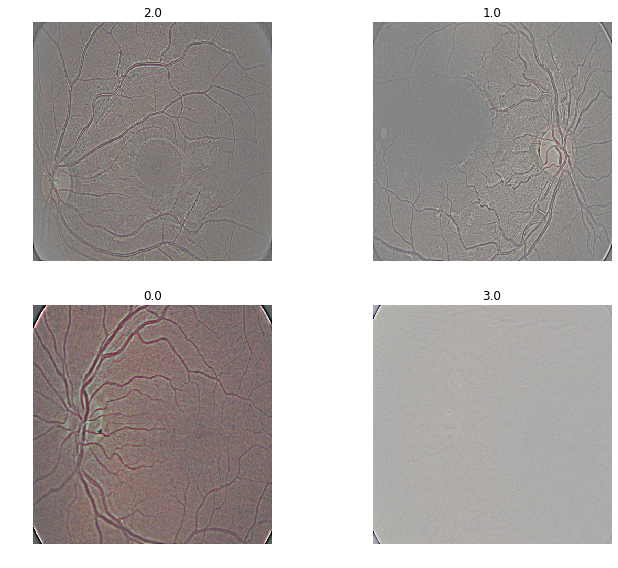

In [94]:
%%time
data.show_batch(rows=2, figsize=(10, 8))

## add test dataset

In [34]:
p = '../input/aptos2019-blindness-detection'
pp = Path(p)
test  = pd.read_csv(pp/'test.csv')

In [35]:
data.add_test(ImageList.from_df(test,
                                '../input/aptos2019-blindness-detection',
                                folder='test_images',
                                suffix='.png'))

CPU times: user 619 ms, sys: 635 ms, total: 1.25 s
Wall time: 10.1 s


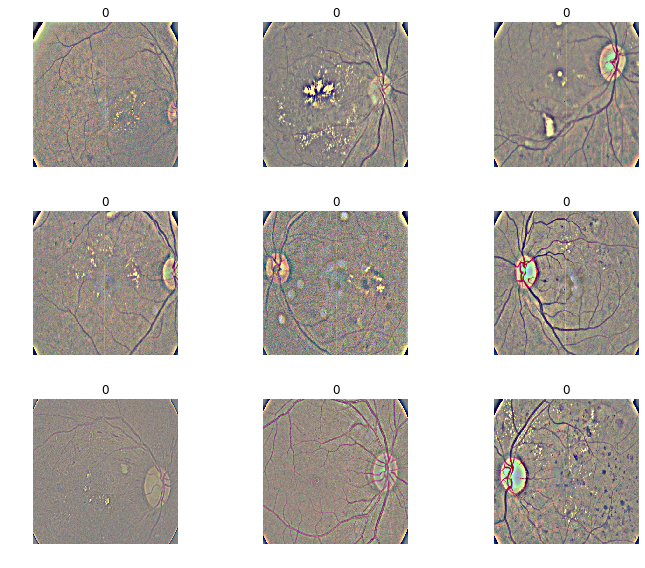

In [36]:
%%time
data.show_batch(rows=3, figsize=(10, 8), ds_type=DatasetType.Test)

# model

In [37]:
model = EfficientNet.from_pretrained(MODEL_NAME, num_classes=1) 

# device = torch.device("cuda")
# model = model.to(device)

learn = Learner(data, model, path=p_o, wd=WD,  metrics=[qwk])

# learn.loss = MSELossFlat


if FP16: learn = learn.to_fp16()

Loaded pretrained weights for efficientnet-b5


# train

In [38]:
%%time
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 34 s, sys: 4.51 s, total: 38.5 s
Wall time: 4min 5s


Min numerical gradient: 6.92E-04
Min loss divided by 10: 5.75E-03


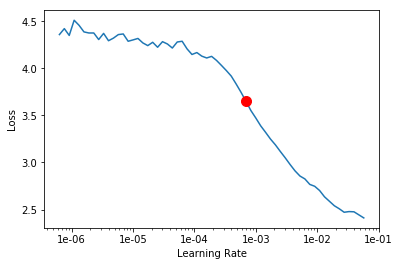

In [39]:
learn.recorder.plot(suggestion=True)

In [40]:
set_torch_seed()
learn.fit_one_cycle(10, max_lr=1e-4, 
                    callbacks=[SaveModelCallback(learn, every='epoch', name=f'{PRFX}_model_finetune')])

epoch,train_loss,valid_loss,qwk,time
0,0.551758,0.624221,0.625135,27:52
1,0.350673,0.293854,0.781284,27:40
2,0.286677,0.331708,0.792903,28:42
3,0.250902,0.342795,0.765605,27:55
4,0.179004,0.305831,0.811860,29:21
5,0.127609,0.342730,0.794990,28:27
6,0.117311,0.319871,0.791075,28:24
7,0.076796,0.307398,0.804540,28:18
8,0.065606,0.302704,0.806921,28:46
9,0.061634,0.303196,0.801601,27:52


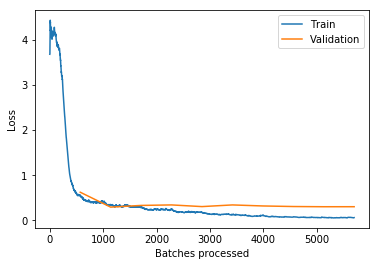

In [41]:
learn.recorder.plot_losses()

In [42]:
!nvidia-smi


Thu Jul 25 00:10:34 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   44C    P0    50W / 300W |  15435MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# validate and thresholding

In [44]:
learn = learn.load(f'{PRFX}_model_finetune_5')

In [45]:
learn = learn.to_fp32()

In [46]:
%%time
set_torch_seed()
preds_val, y_val = learn.TTA(ds_type=DatasetType.Valid)

CPU times: user 29 s, sys: 12.3 s, total: 41.3 s
Wall time: 9min 47s


In [47]:
preds_val = preds_val.numpy().squeeze()
y_val= y_val.numpy()

In [51]:
optnm2coefs = {'simple': [0.5, 1.5, 2.5, 3.5]}

In [52]:
%%time
set_torch_seed()
optR = Hocop1OptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['hocop1'] = optR.coefficients()

CPU times: user 6.47 s, sys: 0 ns, total: 6.47 s
Wall time: 6.47 s


In [53]:
%%time
set_torch_seed()
optR = AbhishekOptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['abhishek'] = optR.coefficients()

CPU times: user 887 ms, sys: 0 ns, total: 887 ms
Wall time: 885 ms


In [54]:
optnm2coefs

{'simple': [0.5, 1.5, 2.5, 3.5],
 'hocop1': [1.0000660342883434,
  1.5000660342883434,
  2.652573865733972,
  3.4838117386365677],
 'abhishek': array([0.502867, 1.38699 , 2.659253, 3.730101])}

In [55]:
optnm2preds_val_grd = {k: bucket(preds_val, coef) for k,coef in optnm2coefs.items()}
optnm2qwk = {k: quadratic_weighted_kappa(y_val, preds) for k,preds in optnm2preds_val_grd.items()}

In [56]:
optnm2qwk

{'simple': 0.8323380799265043,
 'hocop1': 0.8257231171311538,
 'abhishek': 0.8449884905694045}

In [57]:
Counter(y_val).most_common()

[(2.0, 375), (3.0, 150), (0.0, 131), (1.0, 56), (4.0, 18)]

In [58]:
preds_val_grd = optnm2preds_val_grd['simple'].squeeze()

In [59]:
preds_val_grd.mean()

1.8452054794520547

In [60]:
Counter(preds_val_grd).most_common()

[(2.0, 340), (3.0, 150), (0.0, 131), (1.0, 73), (4.0, 36)]

In [61]:
list(zip(preds_val_grd, y_val))[:10]

[(2.0, 2.0),
 (3.0, 3.0),
 (0.0, 0.0),
 (2.0, 2.0),
 (2.0, 2.0),
 (0.0, 2.0),
 (2.0, 4.0),
 (3.0, 2.0),
 (2.0, 2.0),
 (3.0, 3.0)]

In [62]:
(preds_val_grd== y_val.squeeze()).mean()

0.6972602739726027

In [63]:
pickle.dump(optnm2qwk, open(f'{p_o}/optnm2qwk.p', 'wb'))
pickle.dump(optnm2preds_val_grd, open(f'{p_o}/optnm2preds_val_grd.p', 'wb'))
pickle.dump(optnm2coefs, open(f'{p_o}/optnm2coefs.p', 'wb'))

In [64]:
for optnm, coef in optnm2coefs.items():
    print(optnm, optnm2qwk[optnm], coef)
    preds_val_grd = bucket(preds_val, coef)
    display(pd.Series(preds_val_grd.squeeze().astype(int)).value_counts())

simple 0.8323380799265043 [0.5, 1.5, 2.5, 3.5]


2    340
3    150
0    131
1     73
4     36
dtype: int64

hocop1 0.8257231171311538 [1.0000660342883434, 1.5000660342883434, 2.652573865733972, 3.4838117386365677]


2    380
0    144
3    109
1     60
4     37
dtype: int64

abhishek 0.8449884905694045 [0.502867 1.38699  2.659253 3.730101]


2    408
0    131
3    122
1     46
4     23
dtype: int64

# testing

In [65]:
%%time
set_torch_seed()
preds_tst, _ = learn.get_preds(ds_type=DatasetType.Test)
preds_tst = preds_tst.numpy().squeeze()

CPU times: user 12.7 s, sys: 4.67 s, total: 17.4 s
Wall time: 1min 27s


In [66]:
%%time
set_torch_seed()
preds_tst_tta, _ = learn.TTA(ds_type=DatasetType.Test)
preds_tst_tta = preds_tst_tta.numpy().squeeze()

CPU times: user 1min 13s, sys: 26.2 s, total: 1min 40s
Wall time: 8min 52s


In [67]:
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

In [68]:
for optnm, coef in optnm2coefs.items():
    print(optnm, optnm2qwk[optnm], coef)
    preds_tst_grd = bucket(preds_tst, coef)
    display(pd.Series(preds_tst_grd.squeeze().astype(int)).value_counts())

simple 0.8323380799265043 [0.5, 1.5, 2.5, 3.5]


2    940
1    399
0    316
3    229
4     44
dtype: int64

hocop1 0.8257231171311538 [1.0000660342883434, 1.5000660342883434, 2.652573865733972, 3.4838117386365677]


2    1008
0     452
1     263
3     159
4      46
dtype: int64

abhishek 0.8449884905694045 [0.502867 1.38699  2.659253 3.730101]


2    1093
1     317
0     317
3     176
4      25
dtype: int64

In [69]:
for optnm, coef in optnm2coefs.items():
    preds_tst_grd_tta = bucket(preds_tst_tta, coef)
    display(pd.Series(preds_tst_grd_tta.squeeze().astype(int)).value_counts())


2    934
1    399
0    324
3    233
4     38
dtype: int64

2    1010
0     457
1     266
3     156
4      39
dtype: int64

2    1097
0     325
1     314
3     168
4      24
dtype: int64

In [70]:
for optnm, coef in optnm2coefs.items():
    preds_tst_grd = bucket(preds_tst, coef)
    display(pd.Series(preds_tst_grd.squeeze().astype(int)).value_counts())


2    940
1    399
0    316
3    229
4     44
dtype: int64

2    1008
0     452
1     263
3     159
4      46
dtype: int64

2    1093
1     317
0     317
3     176
4      25
dtype: int64

In [71]:
coef = optnm2coefs['simple']
preds_tst_grd = bucket(preds_tst, coef)
pd.Series(preds_tst_grd.squeeze().astype(int)).value_counts()


2    940
1    399
0    316
3    229
4     44
dtype: int64

## submit

In [72]:
subm = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
subm['diagnosis'] = preds_tst_grd.squeeze().astype(int)
subm.head()

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,3
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


In [73]:
subm.diagnosis.value_counts()

2    940
1    399
0    316
3    229
4     44
Name: diagnosis, dtype: int64

In [74]:
subm.to_csv(f"{p_o}/submission.csv", index=False)